In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from QEB import QEB
from biopandas.pdb import PandasPdb
from mrcfile import open as mrc_open
from scipy.interpolate import RegularGridInterpolator
from tqdm.auto import tqdm


In [15]:
with mrc_open('./dataset/emd_11103.map', permissive=True) as mrc:
    # 讀取資訊
    shape = mrc.data.shape  # 檔案的形狀
    header = mrc.header  # 檔案的 header 資訊
    # 讀取數據
    data = mrc.data  # 數據


In [16]:
origin = np.array(header["origin"].item())
grid_size = np.array(header["cella"].item(
)) / np.array([header["mx"].item(), header["my"].item(), header["mz"].item()])
print(f"Origin: {origin}")
print(f"Grid Size: {grid_size}")


Origin: [0. 0. 0.]
Grid Size: [0.49200001 0.49200001 0.49200001]


In [17]:
data = np.einsum('zyx->xyz', data)
data = (data > 0) * data


In [18]:
nx, ny, nz = data.shape[0], data.shape[1], data.shape[2]
x = np.linspace(0, nx - 1, nx) * grid_size[0] + origin[0]
y = np.linspace(0, ny - 1, ny) * grid_size[1] + origin[1]
z = np.linspace(0, nz - 1, nz) * grid_size[2] + origin[2]
interp_func = RegularGridInterpolator((x, y, z), data)


In [19]:
# my method
def generate_points_on_sphere(radius, num_points, center_x=0, center_y=0, center_z=0):
    n = np.arange(1, num_points+1)
    phi = (np.sqrt(5) - 1) / 2
    z = (2*n - 1) / num_points - 1
    x = np.sqrt(1 - z**2) * np.cos(2 * np.pi * n * phi)
    y = np.sqrt(1 - z**2) * np.sin(2 * np.pi * n * phi)
    points = np.column_stack(
        (center_x + radius*x, center_y + radius*y, center_z + radius*z))
    return points


In [20]:
ppdb = PandasPdb().read_pdb('./dataset/6z6u.pdb')
df = ppdb.df['ATOM']
df


record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0            ATOM            1                 N                  SER           
1            ATOM            2                CA                  SER           
2            ATOM            3                 C                  SER           
3            ATOM            4                 O                  SER           
4            ATOM            5                CB                  SER           
...           ...          ...     ...       ...     ...          ...     ...   
70363        ATOM        70675                 C                  GLY           
70364        ATOM        70676                 O                  GLY           
70365        ATOM        70677                 H                  GLY           
70366        ATOM        70678               HA2                  GLY           
70367        ATOM        70679               HA3                  GLY           

      chain_id  residue_number insertion  ...  x_coord  y_coord  z_coord  \
0            A               4            ...   59.742   94.779  100.969   
1            A               4            ...   60.707   93.811  101.584   
2            A               4            ...   62.093   93.921  100.935   
3            A               4            ...   63.078   93.717  101.670   
4            A               4            ...   60.189   92.391  101.512   
...        ...             ...       ...  ...      ...      ...      ...   
70363        6             176            ...  119.580  127.232   81.524   
70364        6             176            ...  118.970  126.818   82.495   
70365        6             176            ...  119.946  127.725   78.585   
70366        6             176            ...  118.252  128.586   80.728   
70367        6             176            ...  118.200  127.158   80.001   

       occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0            1.0     91.41                                  N    NaN      1743  
1            1.0     86.17                                  C    NaN      1745  
2            1.0     62.67                                  C    NaN      1747  
3            1.0     70.54                                  O    NaN      1749  
4            1.0     98.50                                  C    NaN      1751  
...          ...       ...      ...        ...            ...    ...       ...  
70363        1.0     38.02                                  C    NaN    107719  
70364        1.0     48.24                                  O    NaN    107721  
70365        1.0     24.04                                  H    NaN    107723  
70366        1.0     26.98                                  H    NaN    107724  
70367        1.0     26.98                                  H    NaN    107725  

[70368 rows x 21 columns]

In [27]:
atomic = "CA"
df_chosen = df[df["atom_name"] == atomic] if atomic is not None else df
df_well = df_chosen[df_chosen["occupancy"] == 1]
df_defected = df_chosen.drop(df_well.index)
gb_defected = df_defected.groupby(
    ["chain_id", "residue_name", "residue_number"])
new_index = [np.mean(value) for value in gb_defected.groups.values()]
new_df = gb_defected.mean().reset_index()
new_df.index = new_index
df_processed = pd.concat([df_well, new_df])
df_processed


/var/folders/jy/v3npq_7n4_3_w4y5qwm_rplm0000gn/T/ipykernel_92675/1300930345.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_df = gb_defected.mean().reset_index()


record_name  atom_number blank_1 atom_name alt_loc residue_name  \
1.0            ATOM          2.0                CA                  SER   
12.0           ATOM         13.0                CA                  THR   
26.0           ATOM         27.0                CA                  SER   
37.0           ATOM         38.0                CA                  GLN   
54.0           ATOM         55.0                CA                  VAL   
...             ...          ...     ...       ...     ...          ...   
21332.5         NaN      21424.5     NaN       NaN     NaN          LYS   
21608.5         NaN      21700.5     NaN       NaN     NaN          LYS   
23359.5         NaN      23463.5     NaN       NaN     NaN          LYS   
22360.5         NaN      22464.5     NaN       NaN     NaN          SER   
22519.5         NaN      22623.5     NaN       NaN     NaN          THR   

        blank_2 chain_id  residue_number insertion  ...   x_coord  y_coord  \
1.0                    A               4            ...   60.7070  93.8110   
12.0                   A               5            ...   63.4800  94.2310   
26.0                   A               6            ...   66.3940  96.3620   
37.0                   A               7            ...   66.8720  99.7610   
54.0                   A               8            ...   70.4710  98.8050   
...         ...      ...             ...       ...  ...       ...      ...   
21332.5     NaN        r              53       NaN  ...  136.5530  80.6685   
21608.5     NaN        r              68       NaN  ...  152.3775  90.2870   
23359.5     NaN        r             172       NaN  ...  125.6670  76.3715   
22360.5     NaN        r             113       NaN  ...  153.3485  75.6735   
22519.5     NaN        r             122       NaN  ...  156.6510  83.0345   

          z_coord  occupancy  b_factor  blank_4 segment_id element_symbol  \
1.0      101.5840        1.0    86.170                                  C   
12.0      98.9010        1.0    43.580                                  C   
26.0     100.1140        1.0    24.460                                  C   
37.0      98.4510        1.0    21.730                                  C   
54.0      97.7310        1.0    19.150                                  C   
...           ...        ...       ...      ...        ...            ...   
21332.5  116.5830        0.5    18.895      NaN        NaN            NaN   
21608.5  129.9435        0.5    17.775      NaN        NaN            NaN   
23359.5  117.3210        0.5    18.460      NaN        NaN            NaN   
22360.5  136.3355        0.5    19.700      NaN        NaN            NaN   
22519.5  148.1765        0.5    26.725      NaN        NaN            NaN   

        charge  line_idx  
1.0        NaN    1745.0  
12.0       NaN    1762.0  
26.0       NaN    1783.0  
37.0       NaN    1800.0  
54.0       NaN    1826.0  
...        ...       ...  
21332.5    NaN   33880.0  
21608.5    NaN   34299.0  
23359.5    NaN   36931.0  
22360.5    NaN   35435.0  
22519.5    NaN   35668.0  

[4128 rows x 21 columns]

In [28]:
df_processed["residue_name"].nunique()
dict(df_processed.groupby("residue_name").count()["atom_number"])

{'ALA': 288,
 'ARG': 168,
 'ASN': 264,
 'ASP': 312,
 'CYS': 48,
 'GLN': 264,
 'GLU': 360,
 'GLY': 168,
 'HIS': 240,
 'ILE': 144,
 'LEU': 528,
 'LYS': 288,
 'MET': 96,
 'PHE': 144,
 'PRO': 72,
 'SER': 240,
 'THR': 120,
 'TRP': 24,
 'TYR': 216,
 'VAL': 144}

In [58]:
flag = (df[df["residue_number"] == 7])["atom_name"] == "CA"
new_df = (df[df["residue_number"] == 7])[flag]
A = new_df.x_coord.values, new_df.y_coord.values, new_df.z_coord.values


In [59]:
flag2 = (df[df["residue_number"] == 6])["atom_name"] == "CA"
new_df2 = (df[df["residue_number"] == 6])[flag2]
B = new_df2.x_coord.values, new_df2.y_coord.values, new_df2.z_coord.values


In [60]:
np.sqrt(sum((np.array(A[0]) - np.array(B[0]))**2))


2.512042794221468

In [95]:
df.x_coord.min(), df.x_coord.max(), df.y_coord.min(
), df.y_coord.max(), df.z_coord.min(), df.z_coord.max()


(19.382, 85.616, 17.926, 87.08, 23.648, 78.507)

In [609]:
chosen_atomic_indexes = [df[(df["atom_name"] == "CA") & (
    df["residue_number"] == i+5) & (df["chain_id"] == "A")].index for i in range(5)]
atom_points = (np.column_stack((df.x_coord, df.y_coord, df.z_coord)))
interp_func(atom_points[chosen_atomic_indexes])


array([[0.11479107],
       [0.26289679],
       [0.38159082],
       [0.40504672],
       [0.44130949]])

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
1            ATOM            2                CA                  SER           
12           ATOM           13                CA                  THR           
26           ATOM           27                CA                  SER           
37           ATOM           38                CA                  GLN           
54           ATOM           55                CA                  VAL           
...           ...          ...     ...       ...     ...          ...     ...   
70272        ATOM        70584                CA       B          LYS           
70311        ATOM        70623                CA                  HIS           
70329        ATOM        70641                CA                  THR           
70343        ATOM        70655                CA                  LEU           
70362        ATOM        70674                CA                  GLY           

      chain_id  residue_number insertion  ...  x_coord  y_coord  z_coord  \
1            A               4            ...   60.707   93.811  101.584   
12           A               5            ...   63.480   94.231   98.901   
26           A               6            ...   66.394   96.362  100.114   
37           A               7            ...   66.872   99.761   98.451   
54           A               8            ...   70.471   98.805   97.731   
...        ...             ...       ...  ...      ...      ...      ...   
70272        6             172            ...  117.321  125.667   76.373   
70311        6             173            ...  120.783  124.144   76.786   
70329        6             174            ...  123.219  127.067   76.918   
70343        6             175            ...  121.129  129.942   78.226   
70362        6             176            ...  118.806  127.838   80.389   

       occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
1            1.0     86.17                                  C    NaN      1745  
12           1.0     43.58                                  C    NaN      1762  
26           1.0     24.46                                  C    NaN      1783  
37           1.0     21.73                                  C    NaN      1800  
54           1.0     19.15                                  C    NaN      1826  
...          ...       ...      ...        ...            ...    ...       ...  
70272        0.5     18.47                                  C    NaN    107588  
70311        1.0     19.09                                  C    NaN    107641  
70329        1.0     19.06                                  C    NaN    107669  
70343        1.0     18.93                                  C    NaN    107690  
70362        1.0     26.98                                  C    NaN    107717  

[4392 rows x 21 columns]

In [657]:
# chosen_atomic_indexes = [df_CA[(df_CA["atom_name"] == "CA") & (df_CA["residue_number"] == i+5) & (df_CA["chain_id"] == "A")].index for i in range(5)]
from itertools import filterfalse
atom_points = np.column_stack(
    (df_processed.x_coord, df_processed.y_coord, df_processed.z_coord))
START_RAD = 0.01
MAX_RAD = 1.5
GAP = 0.01
RADS = np.round(np.arange(START_RAD, MAX_RAD, GAP), 2)
MAX_POINTS = 8
BASE_NUM_POINTS = 4
MAX_ITER = 30
all_grid_points = {}
distances_to_center = {}
for atomic_index in tqdm(range(len(df_processed))):
    grid_points = {}
    name = tuple(df_processed.iloc[atomic_index, :][[
                 "residue_name", "chain_id", "residue_number"]])
    distances_to_center[name] = []
    for RAD in RADS:
        # The number of grid points we want to search depends on the dense of the ball
        NUM_POINTS = int((RAD**2 / START_RAD**2) * BASE_NUM_POINTS)
        NUM_POINTS = NUM_POINTS if NUM_POINTS <= MAX_POINTS else MAX_POINTS
        NUM_CANDIDATE = NUM_POINTS
        grid_points_for_each_coord = [None] * NUM_POINTS
        grid_points[RAD] = []
        atom_point = atom_points[atomic_index].reshape(-1)
        # Search grid points for `MAX_ITER` otherwise give up
        for k in range(MAX_ITER):
            NUM_CHOSEN = 0
            candidate_points = generate_points_on_sphere(
                RAD, NUM_CANDIDATE, *atom_point)
            # Check the cloest atomic of the grid point is the atomic we want
            for candidate_point in candidate_points:
                distances = ((candidate_point - atom_points)**2).sum(axis=1)
                if (distances[atomic_index] == distances.min()) and (NUM_CHOSEN < NUM_POINTS):
                    grid_points_for_each_coord[NUM_CHOSEN] = candidate_point.tolist(
                    )
                    NUM_CHOSEN += 1
            if isinstance(grid_points_for_each_coord[-1], type(None)):
                # If the number of `None` is less than before than save it
                if grid_points[RAD].count(None) > grid_points_for_each_coord.count(None):
                    grid_points[RAD] = grid_points_for_each_coord
                # Reset the list to find the grid points again
                grid_points_for_each_coord = [None] * NUM_POINTS
                # Increase the number of candidate points
                NUM_CANDIDATE += 2
            else:
                grid_points[RAD] = grid_points_for_each_coord
                break
            if k == MAX_ITER - 1:
                grid_points[RAD] = list(filterfalse(
                    lambda item: not item, grid_points[RAD]))
                print("There are some grid points that could not be found.")
        distances_to_center[name].extend([RAD] * len(grid_points[RAD]))
    all_grid_points[name] = grid_points

# for RAD in RADS:
#     grid_points[RAD] = []
#     NUM_POINTS = int((RAD**2 / START_RAD**2) * BASE_NUM_POINTS)
#     NUM_POINTS = NUM_POINTS if NUM_POINTS <= MAX_POINTS else MAX_POINTS
#     grid_points_for_each_coord = [None] * NUM_POINTS
#     for atomic_index in chosen_atomic_indexes:
#         NUM_CANDIDATE = NUM_POINTS
#         for k in range(50):
#             atom_point = atom_points[atomic_index].reshape(-1)
#             candidate_points = generate_points_on_sphere(RAD, NUM_CANDIDATE, *atom_point)
#             NUM_CHOSEN = 0
#             for candidate_point in candidate_points:
#                 distances = ((candidate_point - atom_points)**2).sum(axis=1)
#                 if (sum(distances[atomic_index] < distances) == NUM_ATOMS - 1) and (NUM_CHOSEN < NUM_POINTS):
#                     grid_points_for_each_coord[NUM_CHOSEN] = candidate_point.tolist()
#                     NUM_CHOSEN += 1
#             if isinstance (grid_points_for_each_coord[-1], type(None)):
#                 if grid_points[RAD].count(None) > grid_points_for_each_coord.count(None):
#                     print(grid_points[RAD])
#                     grid_points[RAD].extend(grid_points_for_each_coord)
#                 grid_points_for_each_coord = [None] * NUM_POINTS
#                 NUM_CANDIDATE += 2
#             else:
#                 grid_points[RAD].extend(grid_points_for_each_coord)
#                 break
#             if k == 10:
#                 print("QQ")
# L = []
# for value in grid_points.values():
#     L.append(np.mean(interp_func(value)))
# plt.plot(np.arange(0.01, 1, 0.01), L, label=f"Residue {j}")
# plt.xlabel("Angstrom")
# plt.ylabel("Electric Density")
# plt.legend(loc=(1.05, -0.05))
# plt.show()


  0%|          | 0/4128 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
from itertools import filterfalse


def generate_grid_points(
        df_processed,
        start_rad=0.01,
        max_rad=0.8,
        gap=0.01,
        max_points=8,
        base_num_points=4,
        max_iter=30
):
    atom_points = np.column_stack(
        (df_processed.x_coord, df_processed.y_coord, df_processed.z_coord))
    rads = np.round(np.arange(start_rad, max_rad, gap), 2)
    grid_points_chosen = {name: [] for name in df_processed["residue_name"].unique()}
    distances_to_center = {name: [] for name in df_processed["residue_name"].unique()}
    data_log = {}
    # for atomic_index in tqdm(range(len(df_processed))):
    for atomic_index in tqdm(range(500)):
        grid_points = {}
        name = df_processed.iloc[atomic_index, :]["residue_name"]
        all_distances_to_center = []
        all_grid_points = []
        for rad in rads:
            # The number of grid points we want to search depends on the dense of the ball
            num_points = int((rad**2 / start_rad**2) * base_num_points)
            num_points = num_points if num_points <= max_points else max_points
            num_candidate = num_points
            grid_points_candidate = [None] * num_points
            grid_points = []
            atom_point = atom_points[atomic_index].reshape(-1)
            # Search grid points for `MAX_ITER` otherwise give up
            for k in range(max_iter):
                num_chosen = 0
                candidate_points = generate_points_on_sphere(
                    rad, num_candidate, *atom_point)
                # Check the cloest atomic of the grid point is the atomic we want
                for candidate_point in candidate_points:
                    distances = ((candidate_point - atom_points)
                                 ** 2).sum(axis=1)
                    if (distances[atomic_index] == distances.min()) and (num_chosen < num_points):
                        grid_points_candidate[num_chosen] = candidate_point.tolist(
                        )
                        num_chosen += 1
                if isinstance(grid_points_candidate[-1], type(None)):
                    # If the number of `None` is less than before than save it
                    if grid_points.count(None) > grid_points_candidate.count(None):
                        grid_points = grid_points_candidate
                    # Reset the list to find the grid points again
                    grid_points_candidate = [None] * num_points
                    # Increase the number of candidate points
                    num_candidate += 2
                else:
                    grid_points = grid_points_candidate
                    break
                if k == max_iter - 1:
                    grid_points = list(filterfalse(
                        lambda item: not item, grid_points))
                    print("There are some grid points that could not be found.")
            all_distances_to_center.extend([rad] * len(grid_points))
            all_grid_points.extend(grid_points)
        grid_points_chosen[name].append(np.array(all_grid_points))
        distances_to_center[name].append(np.array(all_distances_to_center))
        data_log[name] = np.log(interp_func(grid_points_chosen[name]) + 1e-35)
    # grid_points_chosen = {name: np.array(points) for name, points in grid_points_chosen.items()}
    return grid_points_chosen, distances_to_center, data_log


In [30]:
grid_points_chosen, distances_to_center, data = generate_grid_points(df_processed)


  0%|          | 0/500 [00:00<?, ?it/s]

In [122]:
from collections import Counter

def estimate_density(
        grid_points_chosen, 
        distances_to_center, 
        ):
    radius_density = {key: [] for key in grid_points_chosen.keys()}
    for key, value in grid_points_chosen.items():
        for i in range(len(value)):
            counter = Counter(distances_to_center[key][i])
            mean_densities = []
            start = 0
            grid_points = grid_points_chosen[key][i]
            densities = interp_func(grid_points)
            # densities = data[key][i]
            for num in counter.values():
                mean_densities.append(densities[start: start + num].mean())
                start += num
            radius_density[key].append(mean_densities)
    return radius_density

In [124]:
radius_density = estimate_density(grid_points_chosen, distances_to_center)

In [133]:
radius_density["SER"]

[[0.005745788987994719,
  0.005746008962176432,
  0.005743239400452797,
  0.005740186368131624,
  0.005736848374843709,
  0.005733223930219644,
  0.0057293115438904,
  0.005725109725486848,
  0.005720616984639524,
  0.005715831830979282,
  0.0057107527741370925,
  0.005705378323743439,
  0.005699706989429235,
  0.005693737280825313,
  0.005687467707562438,
  0.005680896779271283,
  0.005674023005582736,
  0.005666844896127557,
  0.005659360960536478,
  0.005688230201358788,
  0.005777523827411505,
  0.005904171023874017,
  0.006030800103489335,
  0.006193642605238078,
  0.006367728345759241,
  0.006541523906540509,
  0.006738624573733035,
  0.006961423037499971,
  0.007185240976347281,
  0.007425461303595177,
  0.007726952714599651,
  0.008034835404825268,
  0.008342198345892525,
  0.008649017483287879,
  0.008955268762498247,
  0.009262024493089915,
  0.009591510965120242,
  0.009889435393883619,
  0.01018662345540587,
  0.010482951312749534,
  0.010778367812777915,
  0.01110277656128

In [48]:
bayes_beta = {'SER': 5.1802885758914465,
 'THR': 4.132015078912541,
 'GLN': 4.577172916201444,
 'VAL': 3.7806295630040685,
 'ARG': 5.070975627716907,
 'ASN': 5.218411159800338,
 'TYR': 4.266193235909172,
 'HIS': 3.8409773292825755,
 'ASP': 4.089077822134707,
 'GLU': 4.829476016873442,
 'ALA': 4.262748481211132,
 'ILE': 4.181403027953156,
 'LEU': 4.566145826429574,
 'MET': 5.0048946885085766,
 'PHE': 4.694304926809513,
 'LYS': 4.230842387847599,
 'GLY': 4.026665419506943,
 'PRO': 4.805860327513715,
 'TRP': 2.988233604008519,
 'CYS': 4.131112523910485}

In [113]:
estimated_A_ij_tilde = np.array([-0.97923087, -0.83600065, -1.24441035, -0.74152437, -0.88263261,
       -0.67696797, -0.74972839, -0.91401201, -1.0029652 , -0.97901373,
       -0.89934028, -0.98334835, -0.84231537, -1.24625933, -0.73655487,
       -0.88674222, -0.68270257, -0.75489782, -0.9216866 , -1.0040743 ,
       -0.97272895, -0.90133559, -0.98161057, -0.8261867 , -1.24713404,
       -0.74376584, -0.88993018, -0.67318829, -0.75280906, -0.91681353,
       -1.00705511, -0.97761395, -0.9010861 , -0.9788226 , -0.84177731,
       -1.25433204, -0.74208637, -0.88447855, -0.67945141, -0.74737965,
       -0.91837041, -1.00112835, -0.96897381, -0.89618638, -0.97839306,
       -0.83065211, -1.2474461 , -0.74396969, -0.88136992, -0.67519795,
       -0.75763902, -0.92199423, -0.9994916 , -0.98052919, -0.89086759,
       -0.98270684, -0.83035488, -1.25000629, -0.74569894, -0.8833875 ,
       -0.67713902, -0.75429778, -0.91774918, -1.00048375, -0.97572856,
       -0.89585511, -0.98006455, -0.8345923 , -1.24983044, -0.74096438])

In [129]:
L = [1, 2, 3, 4, 7, 5]
L[[3, 4]]

TypeError: list indices must be integers or slices, not list

In [110]:
from scipy.stats import norm
def plot_density(
    radius_density, 
    bayes_beta, 
    estimated_A_ij_tilde,
    amino_acid = None, 
    num = None, 
    start_rad=0.01,
    max_rad=0.8,
    gap=0.01,
):
    x_axis = np.arange(start_rad, max_rad, gap)
    # If not choose specific amino acid, then plot all types
    radius_density = {amino_acid: radius_density[amino_acid]} if amino_acid is not None else radius_density
    for key, mean_densities in radius_density.items():
        mean_densities = [mean_densities[num]] if num is not None else mean_densities
        for mean_density in mean_densities:
            plt.plot(x_axis, mean_density)
        estimated_sigma = np.sqrt(1 / bayes_beta[key])
        estimated_adjust_ment = np.exp(estimated_A_ij_tilde[num] + 3/2 * (np.log(2 * np.pi * estimated_sigma**2)))
        plt.plot(x_axis, norm.pdf(x_axis, 0, estimated_sigma)*estimated_adjust_ment, "--", label="estimaed gaussian", c="red")
        plt.legend()
        plt.title(key)
        plt.show()

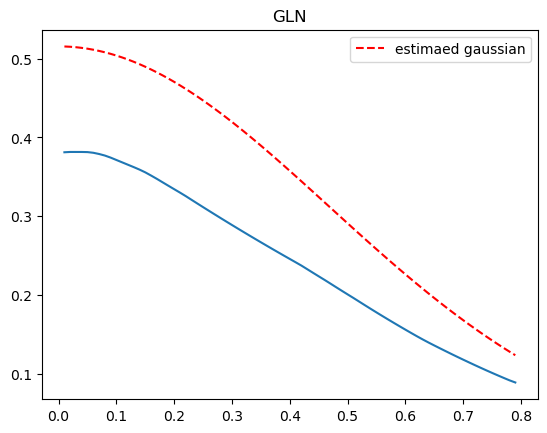

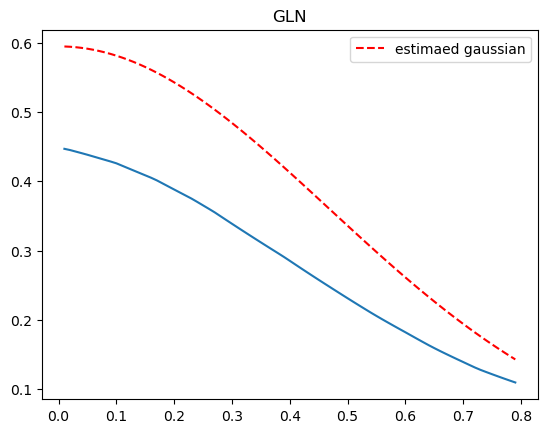

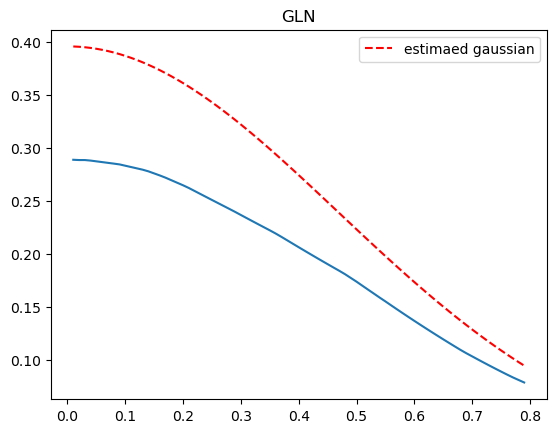

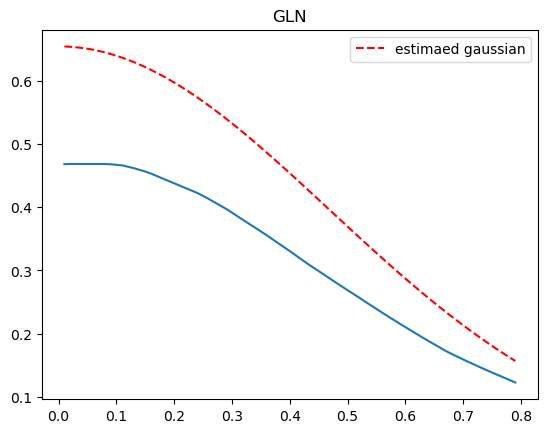

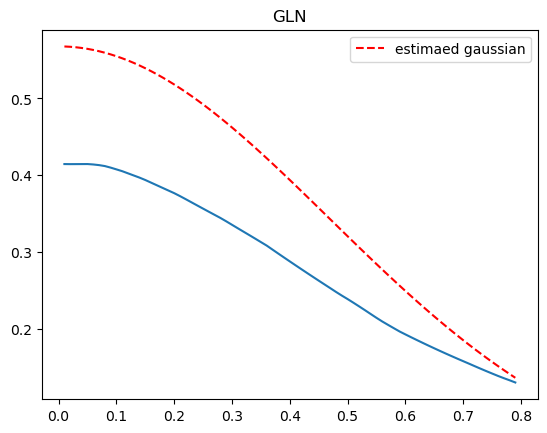

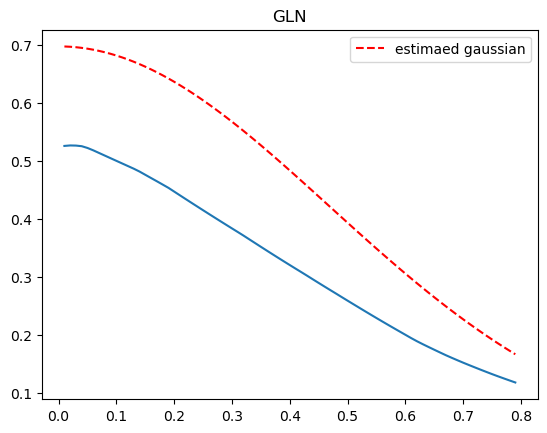

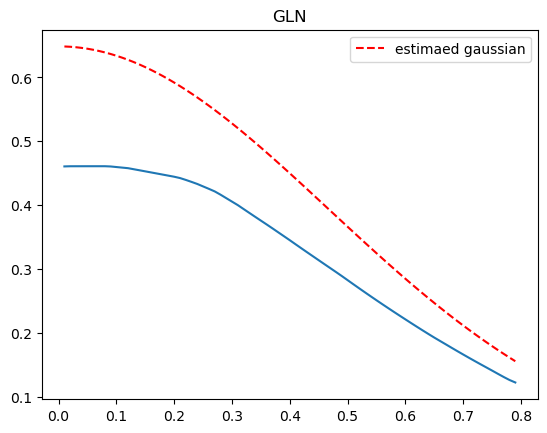

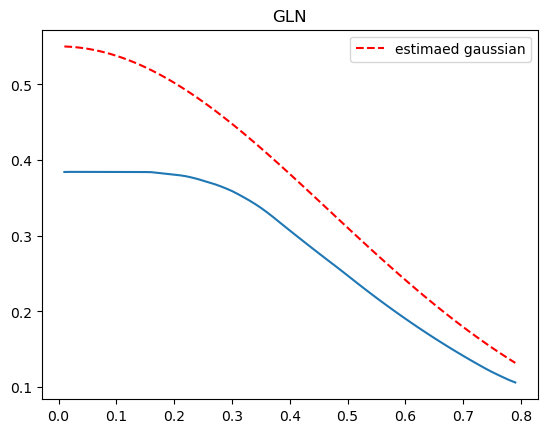

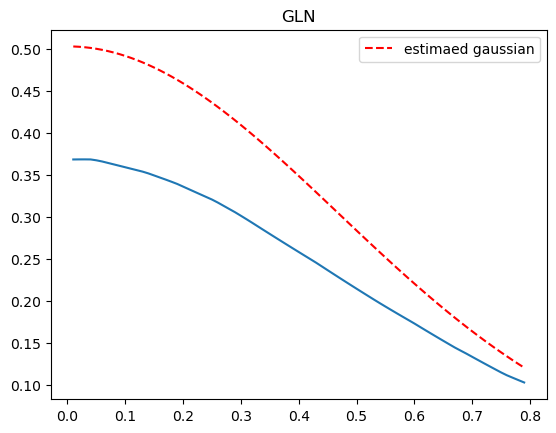

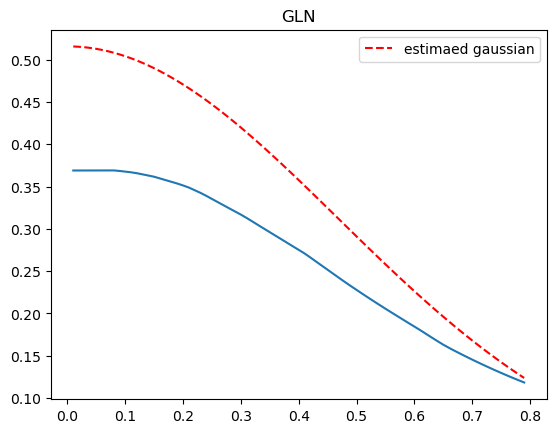

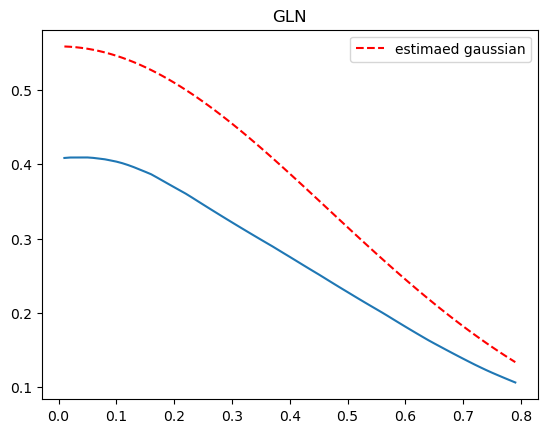

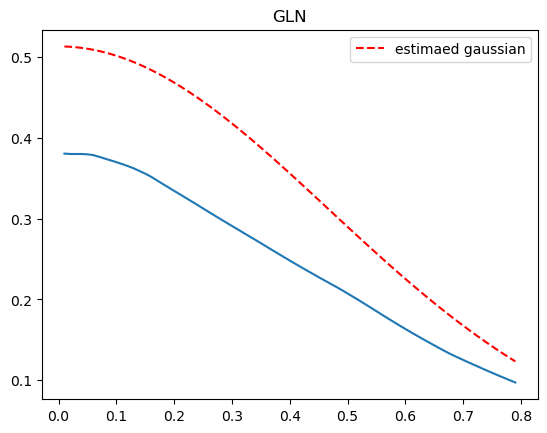

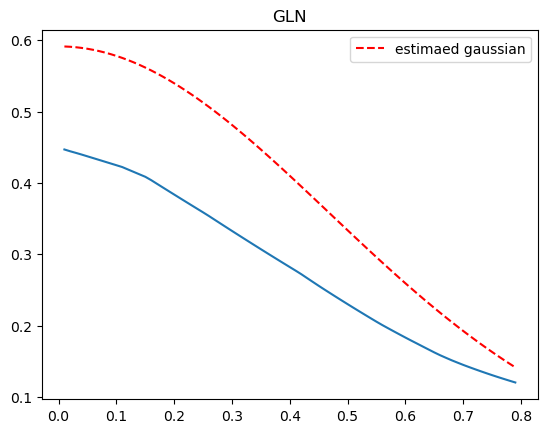

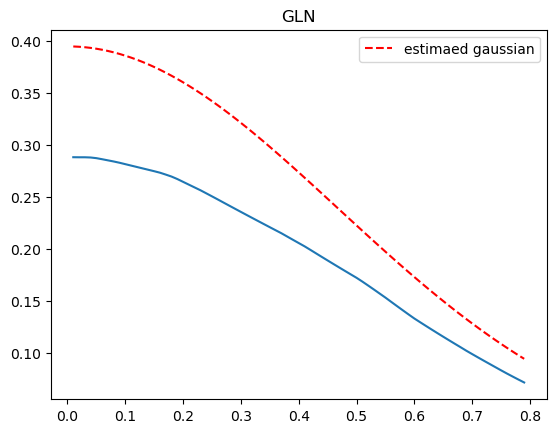

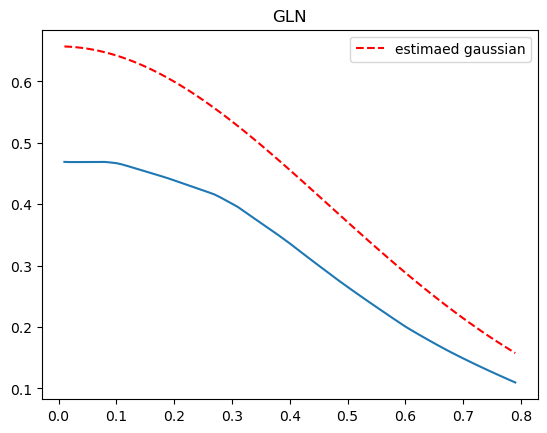

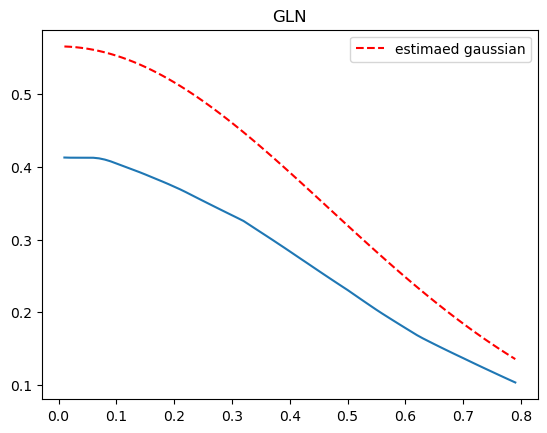

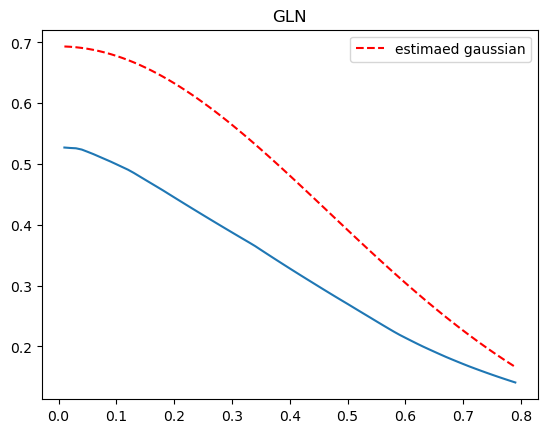

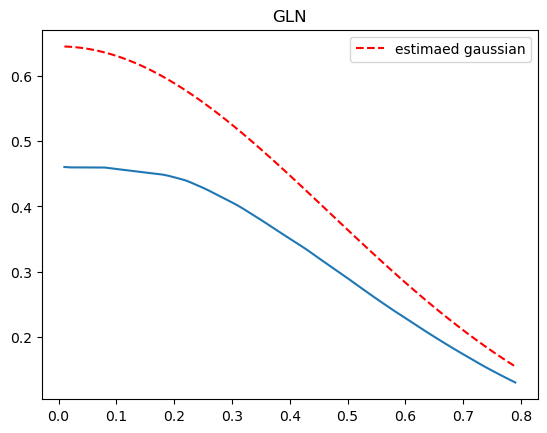

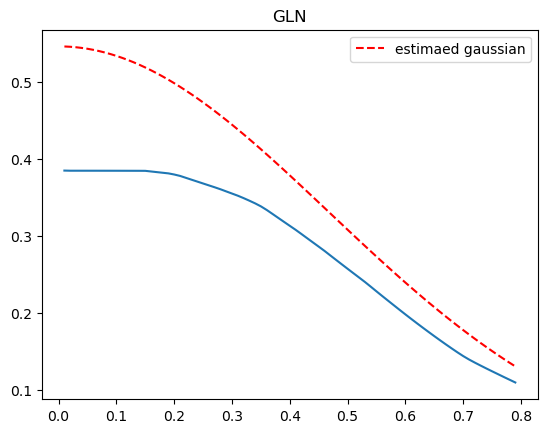

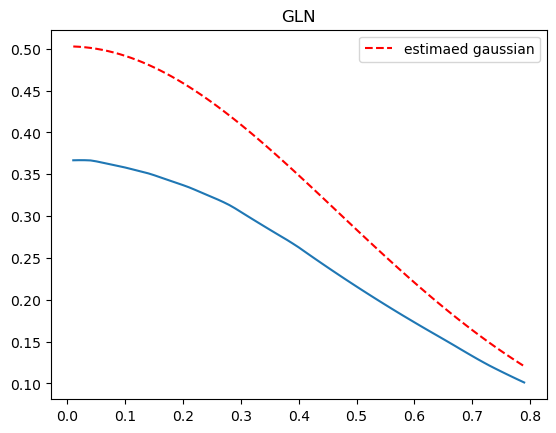

In [114]:
for i in range(20):
    plot_density(radius_density, bayes_beta, estimated_A_ij_tilde, "GLN", num=i)

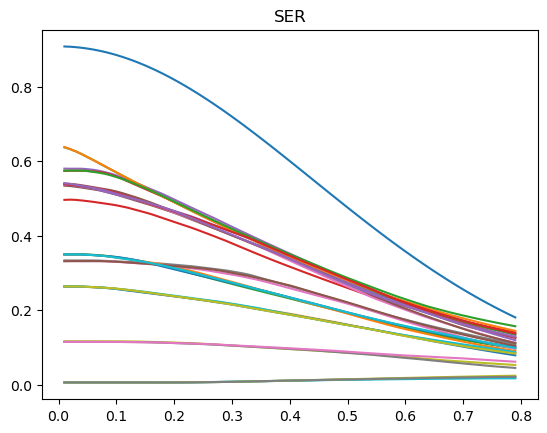

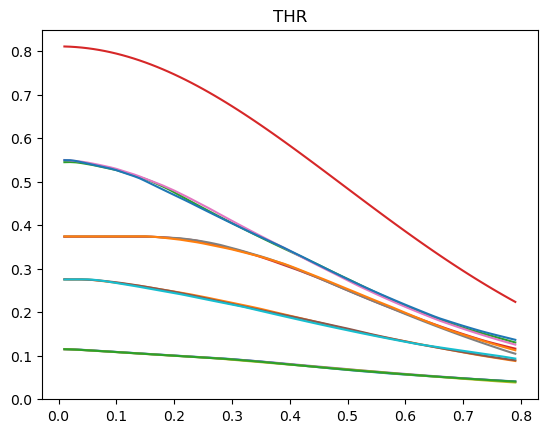

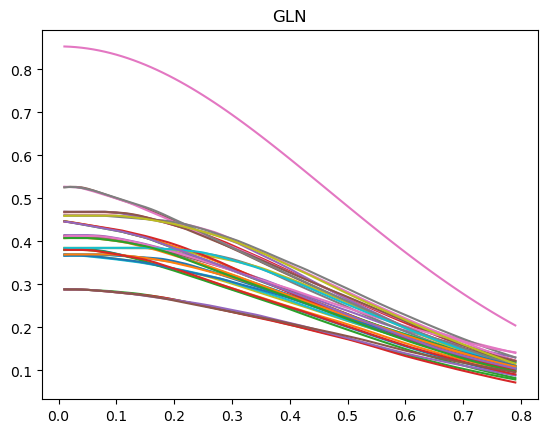

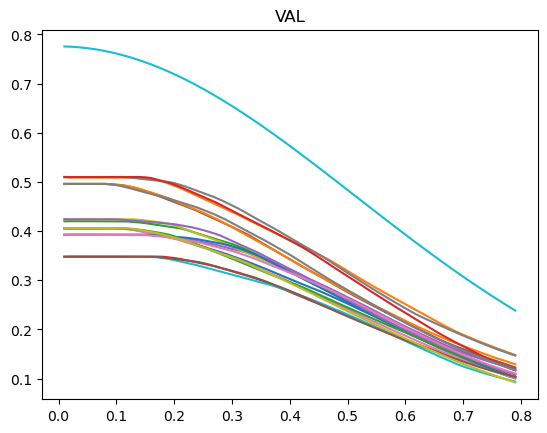

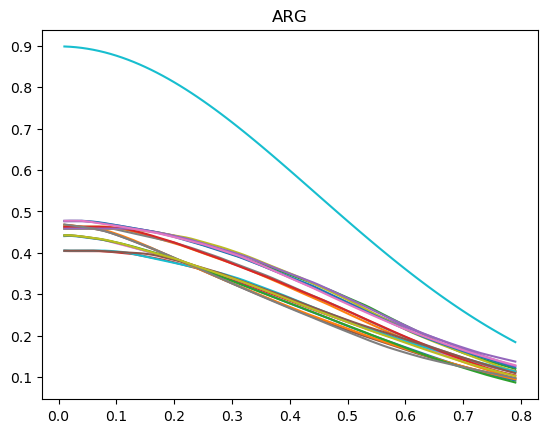

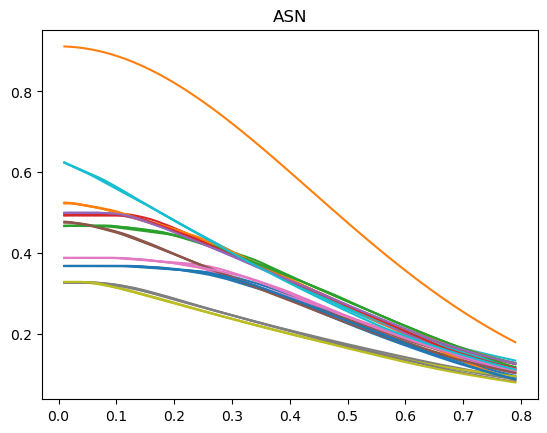

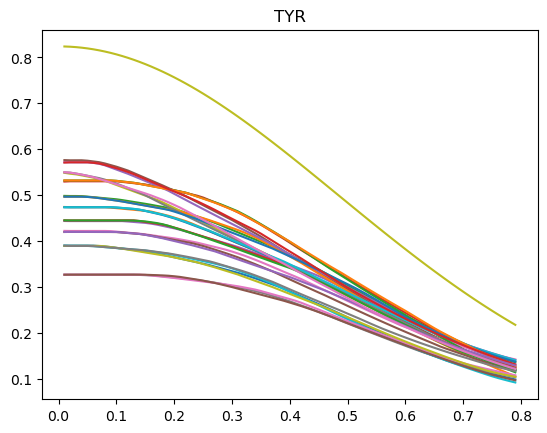

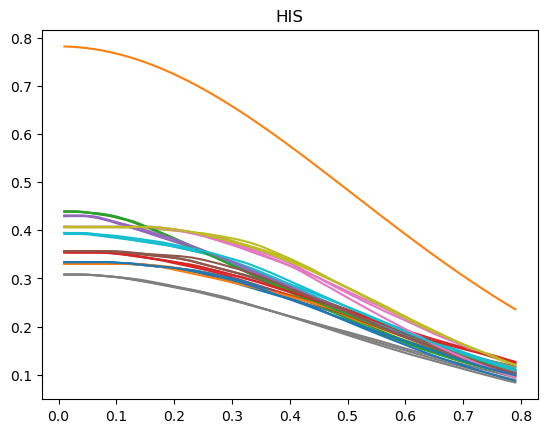

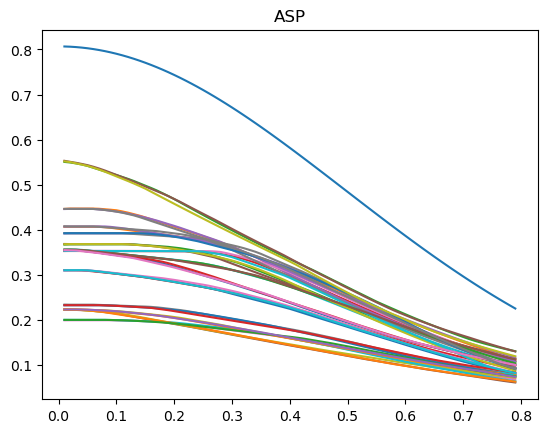

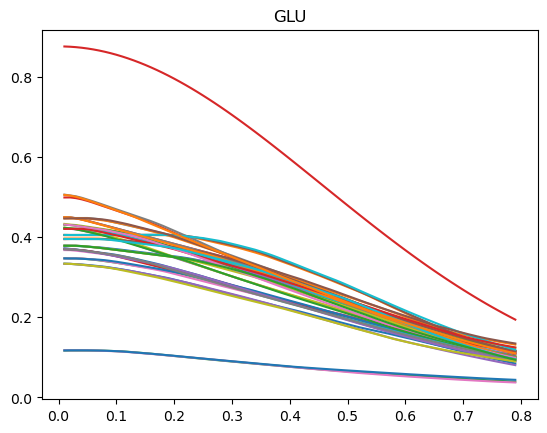

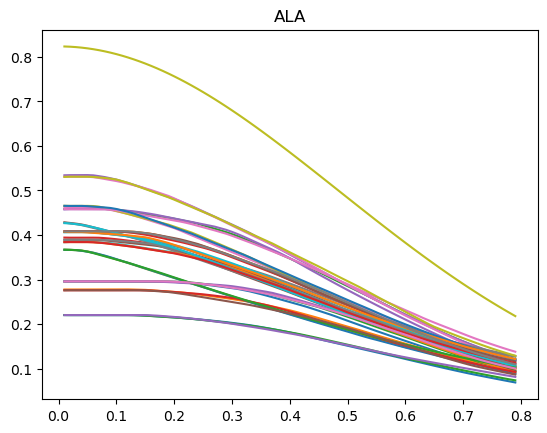

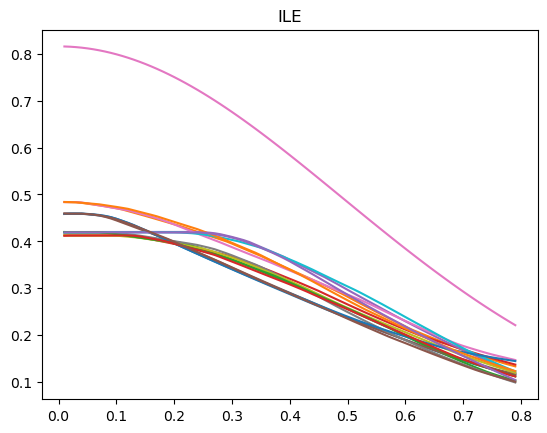

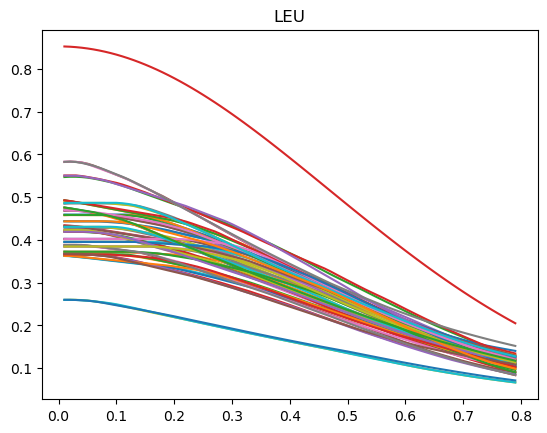

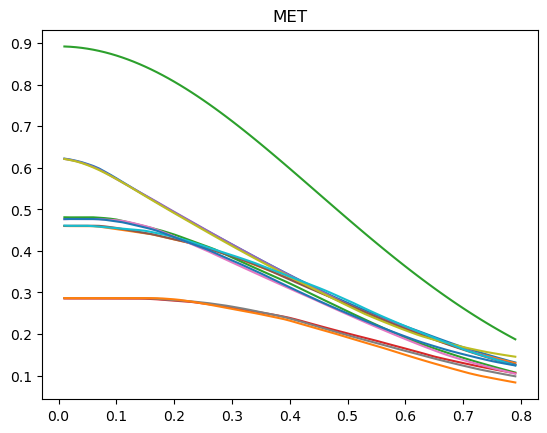

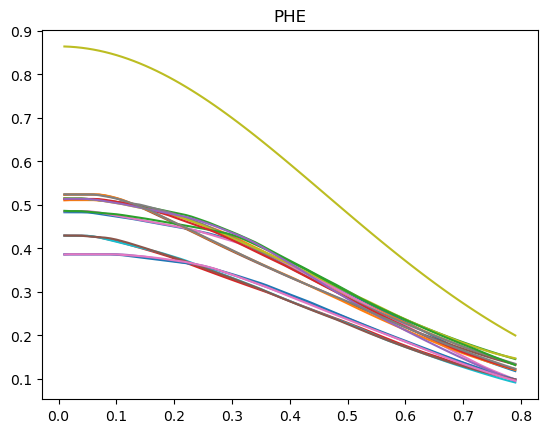

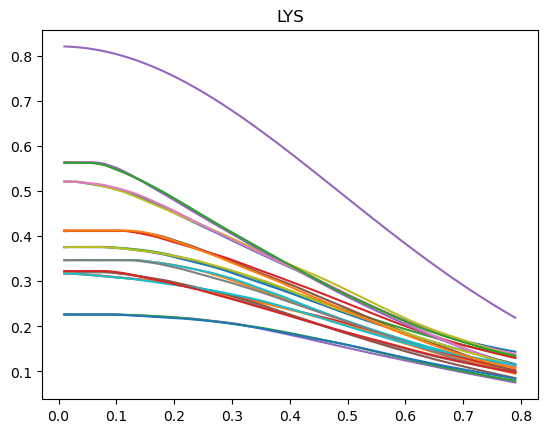

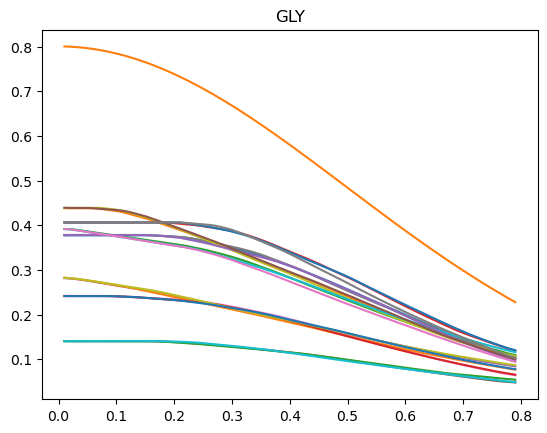

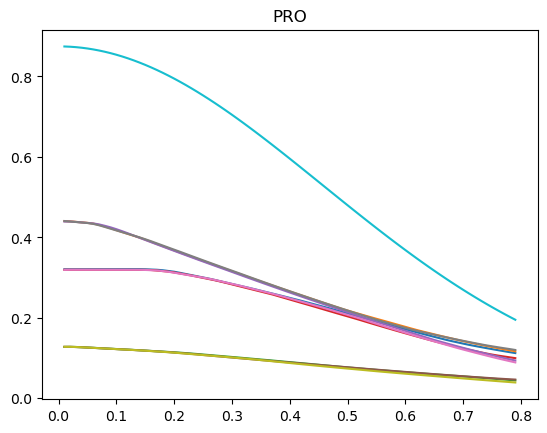

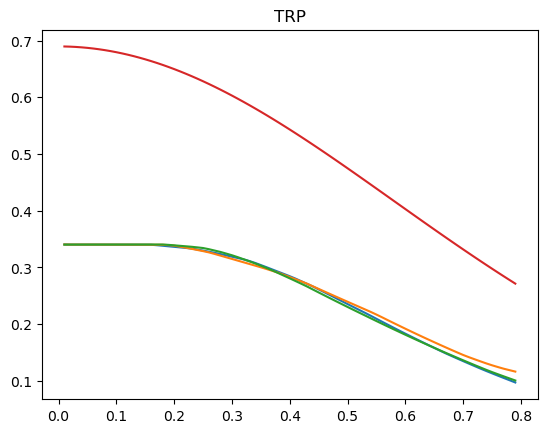

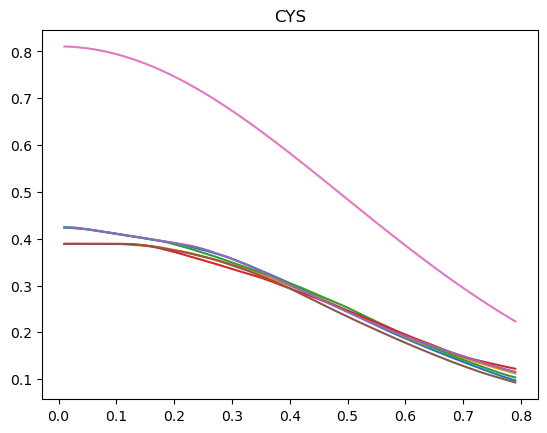

In [38]:
from scipy.stats import norm


x_axis = np.arange(0.01, 0.8, 0.01)

for key, mean_densities in radius_density.items():
    for mean_density in mean_densities:
        plt.plot(x_axis, mean_density)
    estimated_sigma = np.sqrt(1 / estimated[key])
    plt.plot(x_axis, norm.pdf(x_axis, 0, estimated_sigma))
    plt.title(key)
    plt.show()


In [ ]:
for key, value in all_grid_points.items():
    counter = Counter(distances_to_center[key])


In [ ]:
radius_density = {}
for radius, grid_point in zip(distances_to_center, all_grid_points):
    if radius not in radius_density.keys():
        radius_density[radius] = []
    else:
        radius_density.append()


In [703]:
for radius_grid_points in all_grid_points.values():
    L = []
    for grid_points in radius_grid_points.values():
        L.append(np.mean(interp_func(grid_points)))
    plt.plot(radius_grid_points.keys(), L)
plt.show()


AttributeError: 'list' object has no attribute 'values'

In [762]:
from typing import Union, Tuple, Dict


def generate_grid_points(
        df_processed: pd.DataFrame,
        start_rad: Union[int, float] = 0.01,
        max_rad: Union[int, float] = 1.5,
        gap: Union[int, float] = 0.01,
        max_points: Union[int, float] = 8,
        base_num_points: Union[int, float] = 4,
        max_iter: Union[int, float] = 30
):
    atom_points = np.column_stack(
        (df_processed.x_coord, df_processed.y_coord, df_processed.z_coord))
    rads = np.round(np.arange(start_rad, max_rad, gap), 2)
    all_grid_points = {}
    distances_to_center = {}
    # for atomic_index in tqdm(range(len(df_processed))):
    for atomic_index in tqdm(range(10)):
        grid_points = {}
        name = tuple(df_processed.iloc[atomic_index, :][[
                     "residue_name", "chain_id", "residue_number"]])
        distances_to_center[name] = []
        for rad in rads:
            # The number of grid points we want to search depends on the dense of the ball
            num_points = int((rad**2 / start_rad**2) * base_num_points)
            num_points = num_points if num_points <= max_points else max_points
            num_candidate = num_points
            grid_points_for_each_coord = [None] * num_points
            grid_points[rad] = []
            atom_point = atom_points[atomic_index].reshape(-1)
            # Search grid points for `MAX_ITER` otherwise give up
            for k in range(max_iter):
                num_chosen = 0
                candidate_points = generate_points_on_sphere(
                    rad, num_candidate, *atom_point)
                # Check the cloest atomic of the grid point is the atomic we want
                for candidate_point in candidate_points:
                    distances = ((candidate_point - atom_points)
                                 ** 2).sum(axis=1)
                    if (distances[atomic_index] == distances.min()) and (num_chosen < num_points):
                        grid_points_for_each_coord[num_chosen] = candidate_point.tolist(
                        )
                        num_chosen += 1
                if isinstance(grid_points_for_each_coord[-1], type(None)):
                    # If the number of `None` is less than before than save it
                    if grid_points[rad].count(None) > grid_points_for_each_coord.count(None):
                        grid_points[rad] = grid_points_for_each_coord
                    # Reset the list to find the grid points again
                    grid_points_for_each_coord = [None] * num_points
                    # Increase the number of candidate points
                    num_candidate += 2
                else:
                    grid_points[rad] = grid_points_for_each_coord
                    break
                if k == max_iter - 1:
                    grid_points[rad] = list(filterfalse(
                        lambda item: not item, grid_points[rad]))
                    print("There are some grid points that could not be found.")
            distances_to_center[name].extend([rad] * len(grid_points[rad]))
        all_grid_points[name] = grid_points
    return all_grid_points, distances_to_center


In [763]:
all_grid_points, distances_to_center = generate_grid_points(df_processed)


  0%|          | 0/10 [00:00<?, ?it/s]

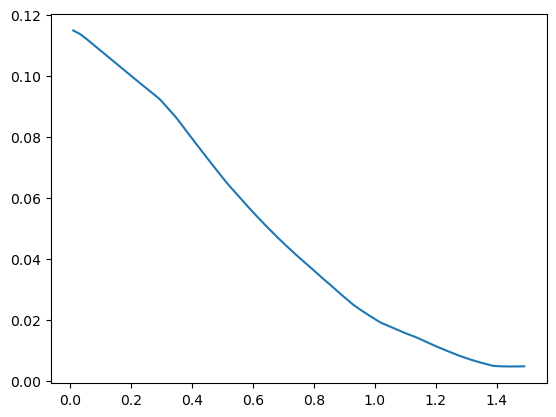

In [765]:
radius_density = {}
i = 0
for radius_grid_points in all_grid_points.values():
    L = []
    for grid_points in radius_grid_points.values():
        L.append(np.mean(interp_func(grid_points)))
    if i == 1:
        plt.plot(radius_grid_points.keys(), L)
    i += 1
plt.show()


In [ ]:
all_grid_points[]


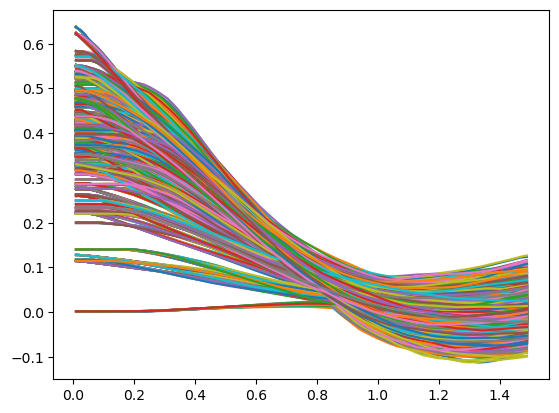

In [687]:
radius_density = {}
for radius_grid_points in all_grid_points.values():
    L = []
    for grid_points in radius_grid_points.values():
        L.append(np.mean(interp_func(grid_points)))
    plt.plot(radius_grid_points.keys(), L)
plt.show()


In [661]:
distances_to_center[('SER', 'A', 4)]


[0.01,
 0.01,
 0.01,
 0.01,
 0.02,
 0.02,
 0.02,
 0.02,
 0.02,
 0.02,
 0.02,
 0.02,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.18,
 0.18,
 0.18,
 0.18,
 0.18,
 0.18,
 0.18,
 0.18,
 0.19,
 0.19,
 0.19,
 0.19,


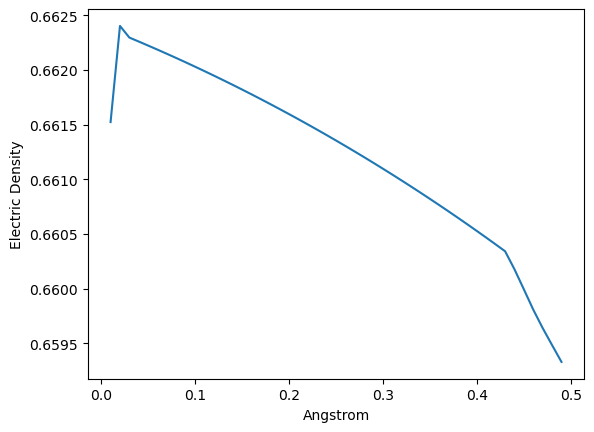

In [235]:
L = []
for value in grid_points.values():
    # print(np.array(value))
    # print(interp_func(list(value)))
    L.append(np.mean(interp_func(value)))
plt.plot(np.arange(0.01, 0.5, 0.01), L)
plt.xlabel("Angstrom")
plt.ylabel("Electric Density")
plt.show()


In [323]:
grid_points


{0.01: [[31.531112054059182, 41.061269486866166, 48.45133333333333],
  [31.533381079899108, 41.06734120889761, 48.452],
  [31.536363272349565, 41.05861220679103, 48.452666666666666],
  [31.526677692927525, 41.06411732710042, 48.45333333333333]],
 0.02: [[31.52922410811836, 41.059539973732335, 48.44166666666666],
  [31.533762159798215, 41.07168341779522, 48.443],
  [31.53972654469913, 41.05422541358207, 48.44433333333333],
  [31.520355385855048, 41.06523565420085, 48.44566666666667],
  [31.545051236098214, 41.07066500994684, 48.446999999999996],
  [31.528981952991177, 41.04805206540489, 48.44833333333333],
  [31.525404739507128, 41.07762321189674, 48.449666666666666],
  [31.54926952209865, 41.05705739662367, 48.451],
  [31.51633897227489, 41.056121569954406, 48.45233333333333],
  [31.54088652262581, 41.079852040767015, 48.45366666666666],
  [31.53870997221291, 41.04479470882105, 48.455],
  [31.516173427598023, 41.072750342647204, 48.45633333333333],
  [31.552260305996683, 41.06723332424

In [56]:
df.atom_name.unique()


array(['N', 'CA', 'C', 'O', 'CB', 'CG1', 'CG2', 'CG', 'CD1', 'CD2', 'OG',
       'CD', 'OD1', 'OD2', 'CE', 'NZ', 'OG1', 'ND2', 'NE1', 'CE2', 'CE3',
       'CZ2', 'CZ3', 'CH2', 'ND1', 'CE1', 'NE2', 'OE1', 'OE2', 'CZ', 'OH',
       'NE', 'NH1', 'NH2', 'SD', 'SG', 'OXT'], dtype=object)

In [4]:
new_df = df[df["residue_name"] == 'TYR']
num = new_df["residue_number"].unique()[0]
amino_acid = new_df[new_df["residue_number"] == num]
atom_points = np.column_stack(
    (amino_acid.x_coord, amino_acid.y_coord, amino_acid.z_coord))


In [5]:
atom = "N"
atom_df = df[df["atom_name"] == atom]
atom_points = np.column_stack(
    (atom_df.x_coord, atom_df.y_coord, atom_df.z_coord))
atom_points.shape


(574, 3)

In [6]:
grid_points_with_atoms = {}
for atom in df.atom_name.unique():
    print(atom)
    atom_df = df[df["atom_name"] == atom]
    atom_points = np.column_stack((atom_df.x_coord, atom_df.y_coord, atom_df.z_coord))
    START_RAD = 0.5
    MAX_RAD = 2
    GAP = 0.01
    RADS = np.round(np.arange(START_RAD, MAX_RAD, GAP), 2)
    MAX_POINTS = 30
    NUM_ATOMS = len(atom_points)
    BASE_NUM_POINTS = 2
    grid_points = {}
    for RAD in RADS:
        grid_points[RAD] = []
        NUM_POINTS = int((RAD**2 / START_RAD**2) * BASE_NUM_POINTS)
        NUM_POINTS = NUM_POINTS if NUM_POINTS <= MAX_POINTS else MAX_POINTS
        grid_points_for_each_coord = [None] * NUM_POINTS
        for i in range(NUM_ATOMS):
            NUM_CANDIDATE = NUM_POINTS
            for k in range(50):
                atom_point = atom_points[i]
                candidate_points = generate_points_on_sphere(RAD, NUM_CANDIDATE, *atom_point)
                candidate_points = candidate_points.reshape((-1, 3))
                NUM_CHOSEN = 0
                for candidate_point in candidate_points:
                    distances = ((candidate_point - atom_points)**2).sum(axis=1)
                    if (sum(distances[i] < distances) == NUM_ATOMS - 1) and (NUM_CHOSEN < NUM_POINTS):
                        grid_points_for_each_coord[NUM_CHOSEN] = candidate_point.tolist()
                        NUM_CHOSEN += 1
                if isinstance (grid_points_for_each_coord[-1], type(None)):
                    if grid_points[RAD].count(None) > grid_points_for_each_coord.count(None):  
                        print(grid_points[RAD])         
                        grid_points[RAD].extend(grid_points_for_each_coord)                                                                                                
                    grid_points_for_each_coord = [None] * NUM_POINTS
                    NUM_CANDIDATE += 2
                else:
                    grid_points[RAD].extend(grid_points_for_each_coord)
                    break  
                if k == 10:
                    print("QQ")
    grid_points_with_atoms[atom] = grid_points
        

N
CA
C
O
CB
CG1
CG2
CG
CD1
CD2
OG
CD
OD1
OD2
CE
NZ
OG1
ND2
NE1
CE2
CE3
CZ2
CZ3
CH2
ND1
CE1
NE2
OE1
OE2
CZ
OH
NE
NH1
NH2
SD
SG
OXT


In [ ]:
df_defected["y_coord"].mean()


chain_id  residue_name  residue_number
1         ARG           156               63.9150
          ASN           109               71.8400
          GLU           140               83.2375
          ILE           133               85.7600
          LEU           72                91.8010
                                           ...   
r         LYS           53                80.6685
                        68                90.2870
                        172               76.3715
          SER           113               75.6735
          THR           122               83.0345
Name: y_coord, Length: 264, dtype: float64

In [ ]:
df_defected["y_coord"].mean()


chain_id  residue_name  residue_number
1         ARG           156               63.9150
          ASN           109               71.8400
          GLU           140               83.2375
          ILE           133               85.7600
          LEU           72                91.8010
                                           ...   
r         LYS           53                80.6685
                        68                90.2870
                        172               76.3715
          SER           113               75.6735
          THR           122               83.0345
Name: y_coord, Length: 264, dtype: float64

In [93]:
RADS


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.

In [105]:
grid_points[0.01]


[[35.693614198196244, 51.3621500824516, 71.322],
 [35.700757128985494, 51.37662709427904, 71.332]]

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
29        ATOM           30                CA                  ALA           

   chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
29        A               5            ...    35.7   51.368   71.327   

    occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
29        1.0     78.76                                  C    NaN       398  

[1 rows x 21 columns]

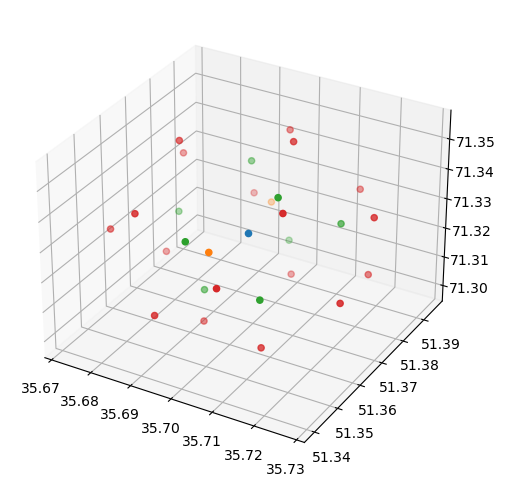

In [104]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(atom_points[:, 0], atom_points[:, 1], atom_points[:, 2])
for i in range(3):
    pts2 = np.array(grid_points[RADS[i]])
    ax.scatter(pts2[:, 0], pts2[:, 1], pts2[:, 2])
plt.show()


In [26]:
points = np.vstack(list(grid_points.values()))


In [25]:
data.shape[0]


(336, 336, 336)

In [26]:
n = data.shape[0]
x = np.linspace(0, n - 1, n)
y = np.linspace(0, n - 1, n)
z = np.linspace(0, n - 1, n)
interp_func = RegularGridInterpolator((x, y, z), data)


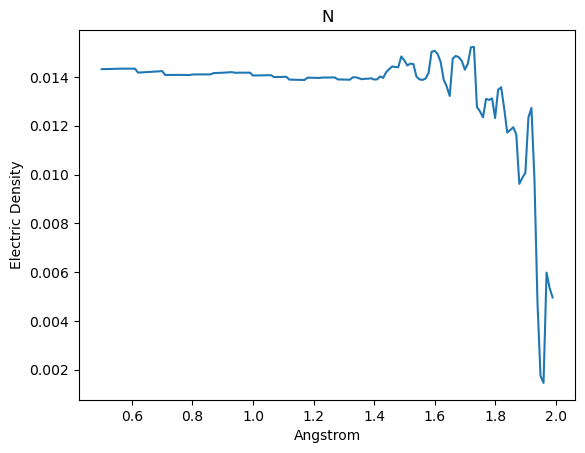

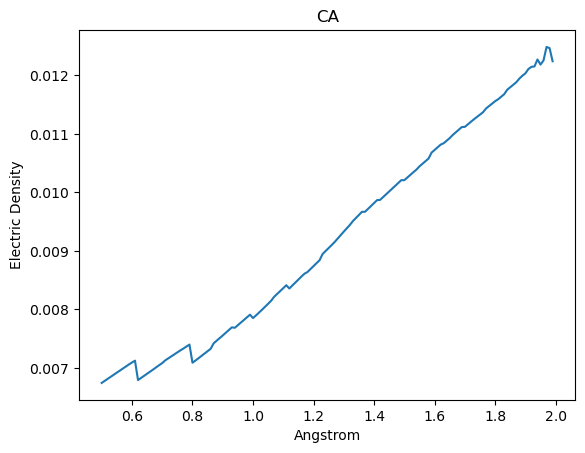

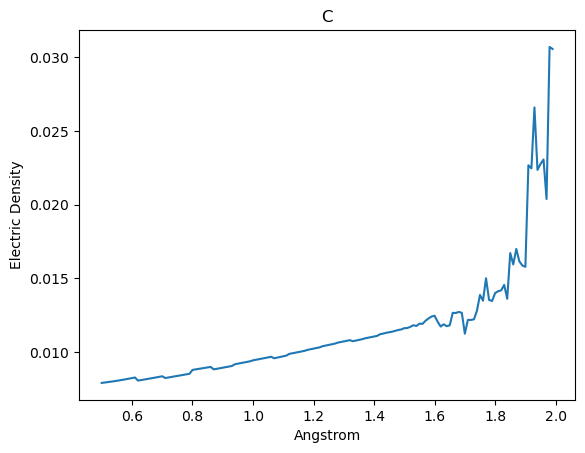

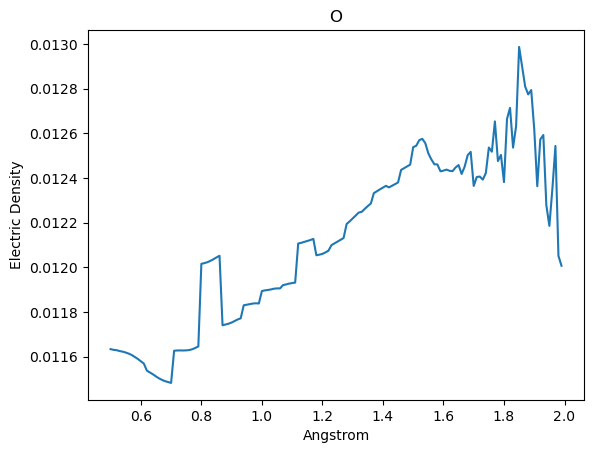

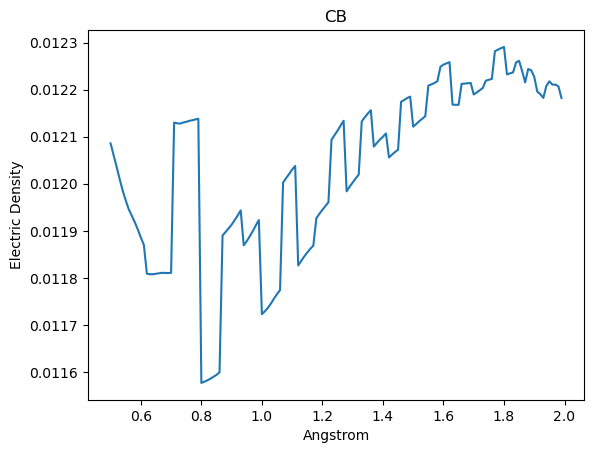

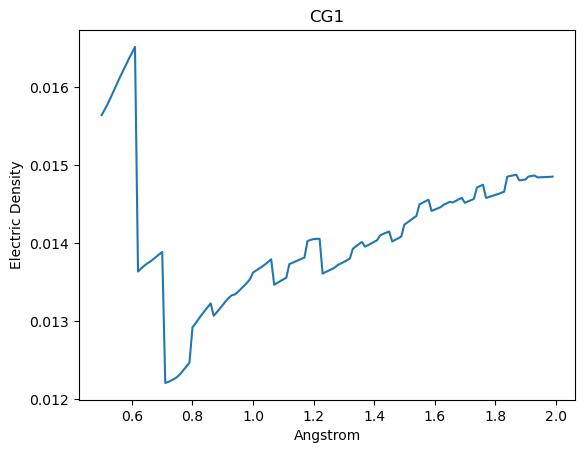

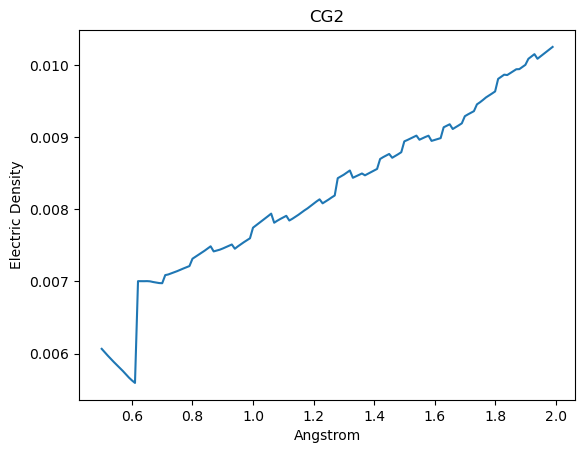

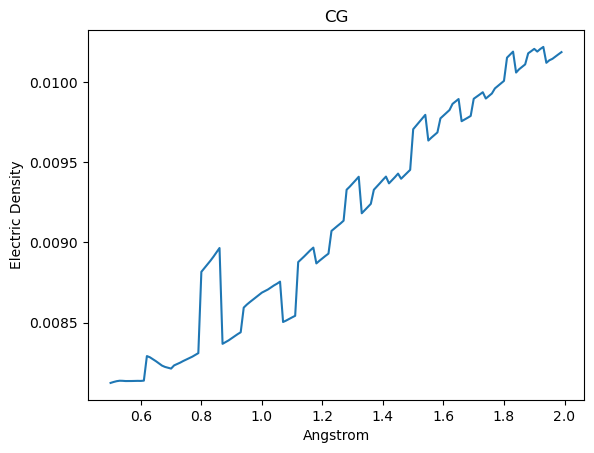

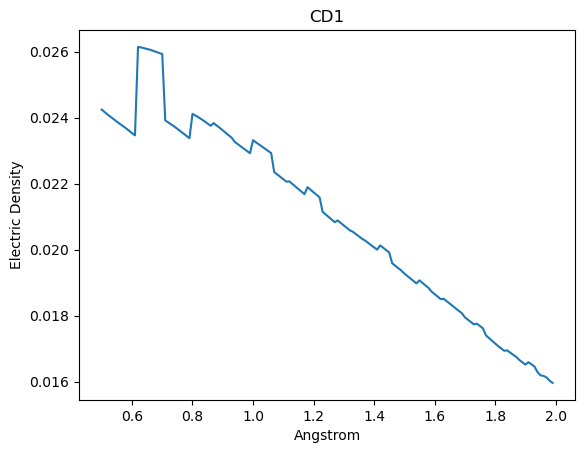

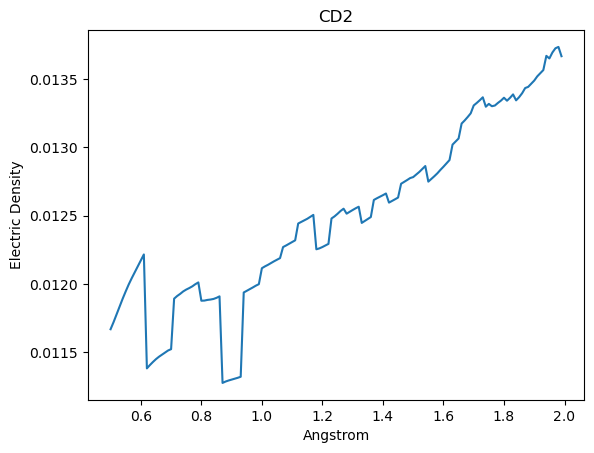

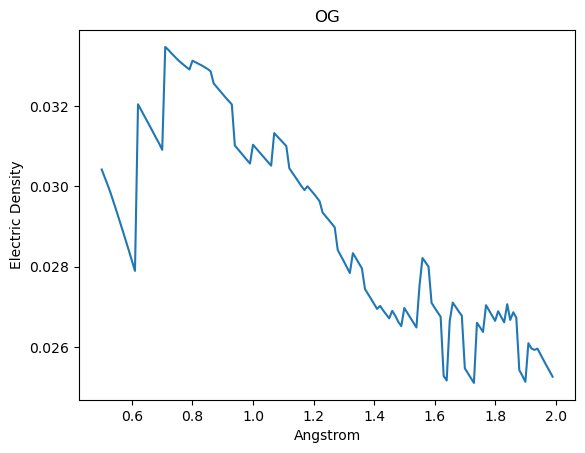

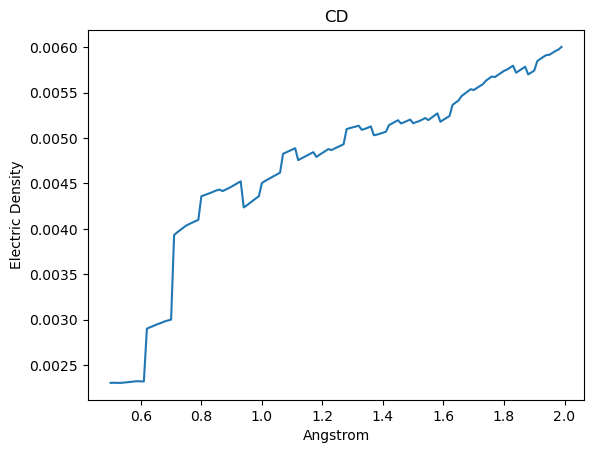

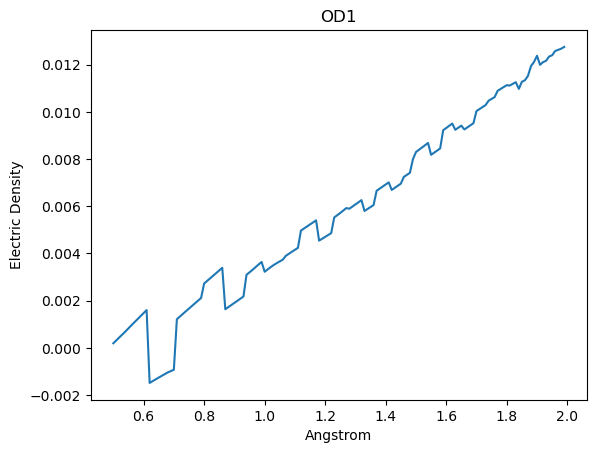

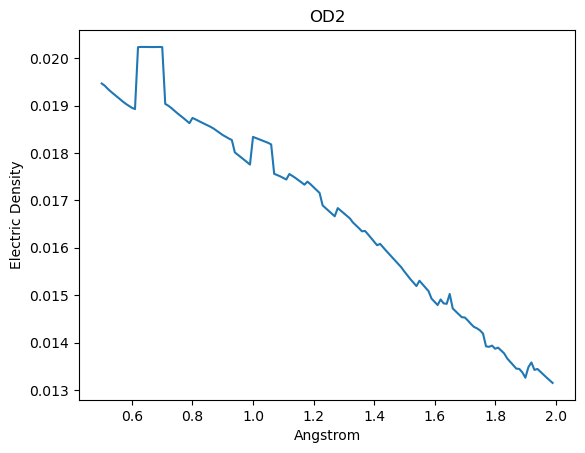

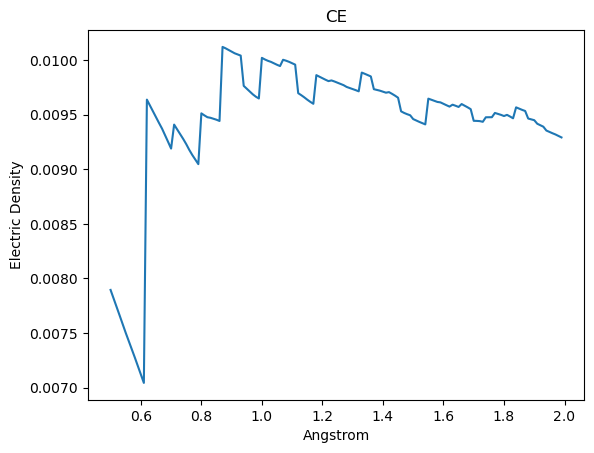

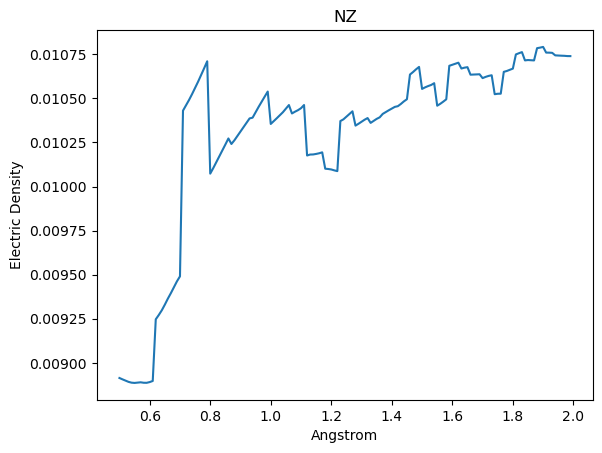

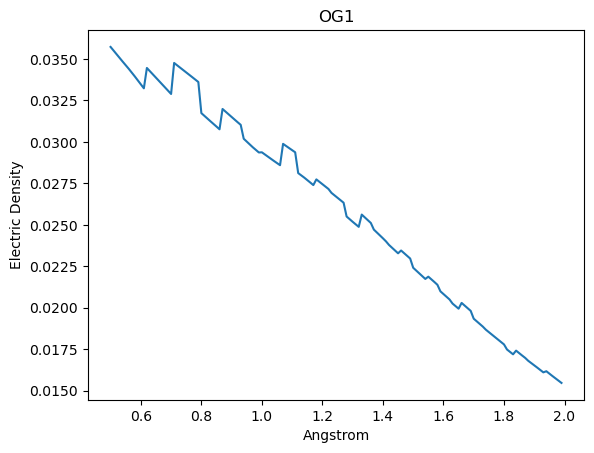

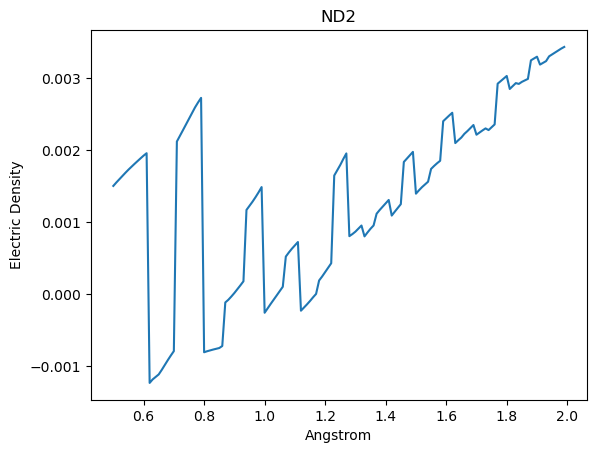

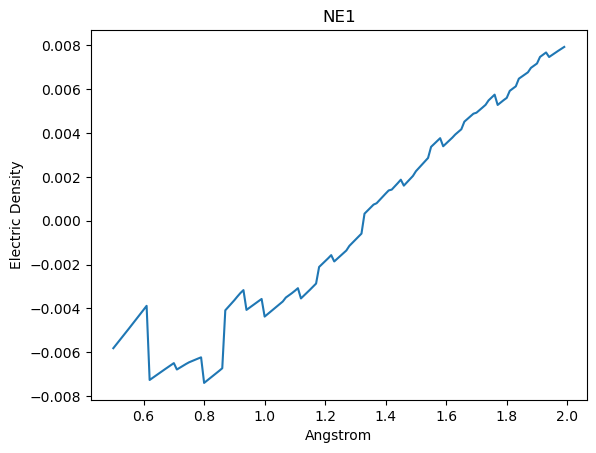

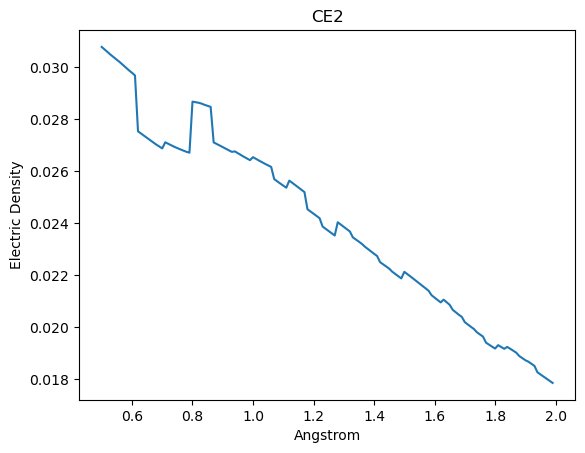

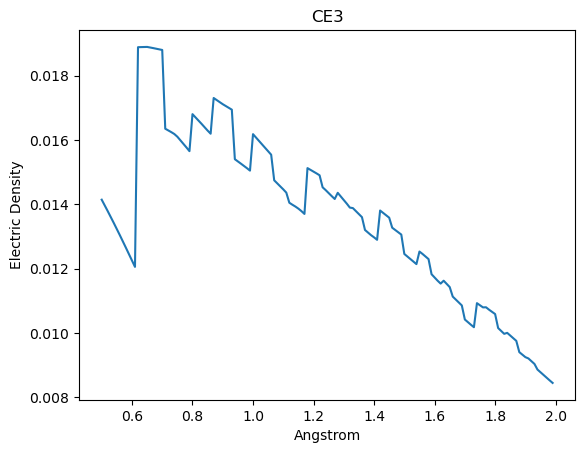

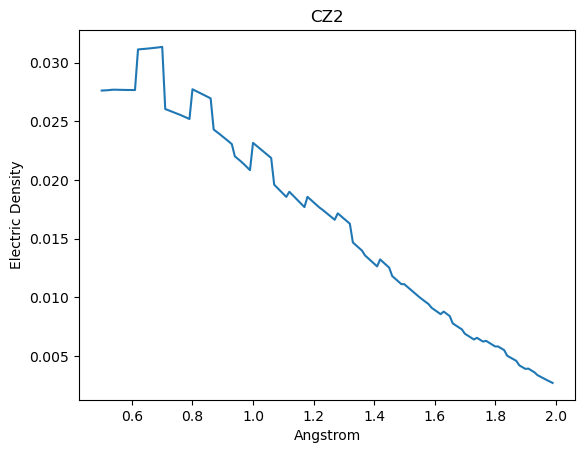

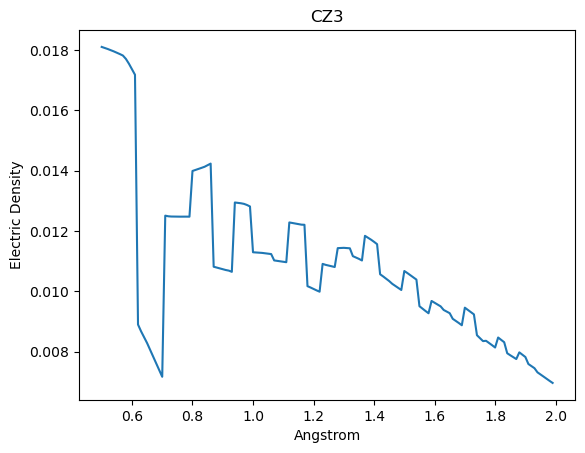

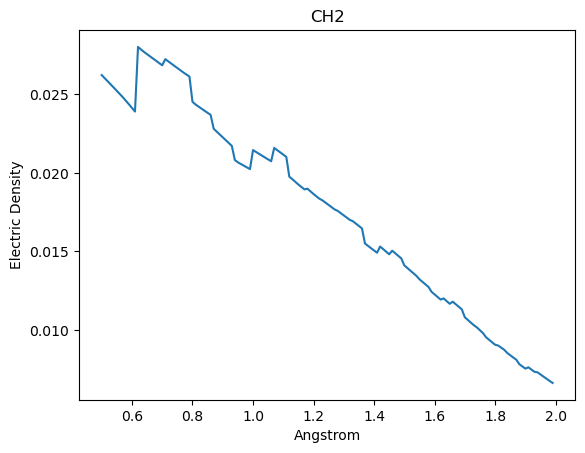

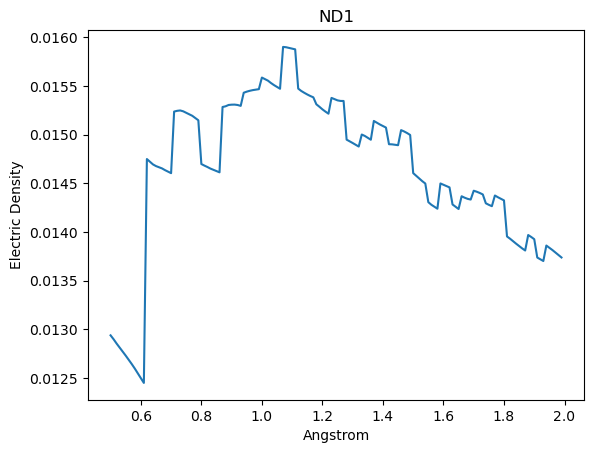

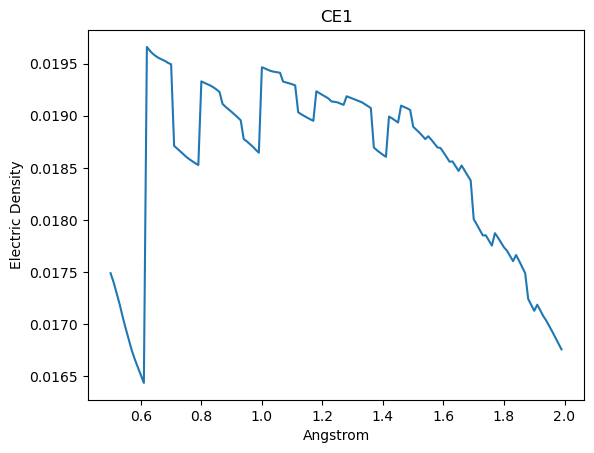

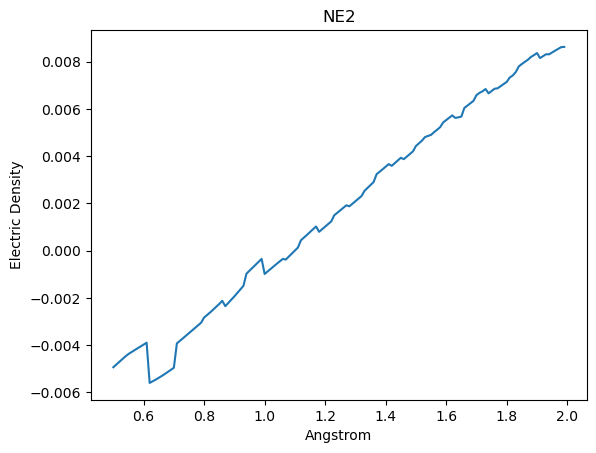

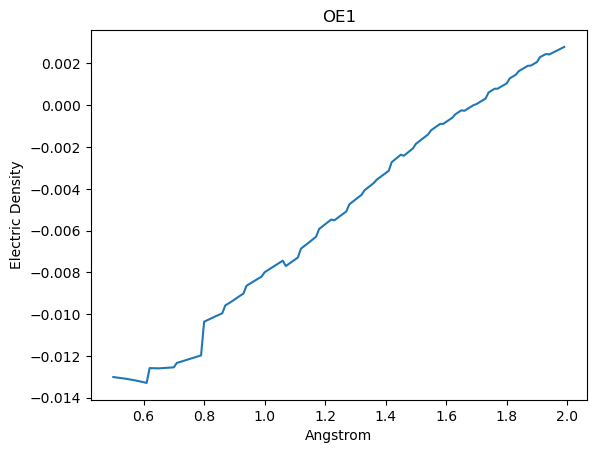

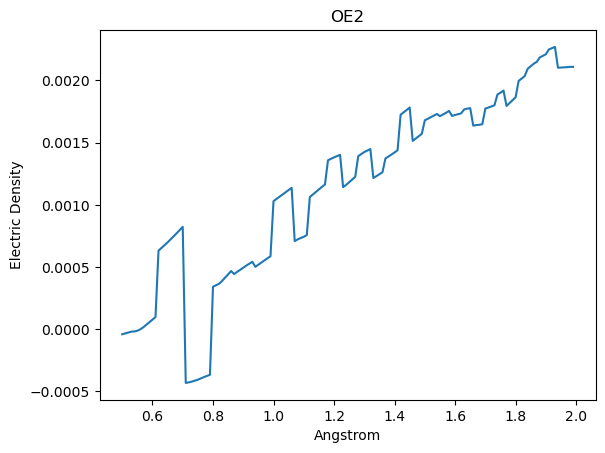

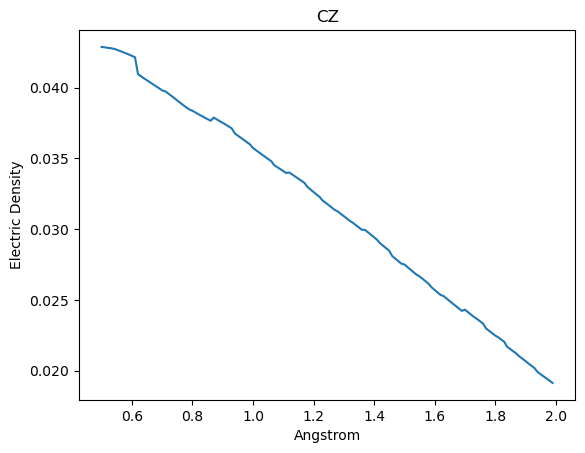

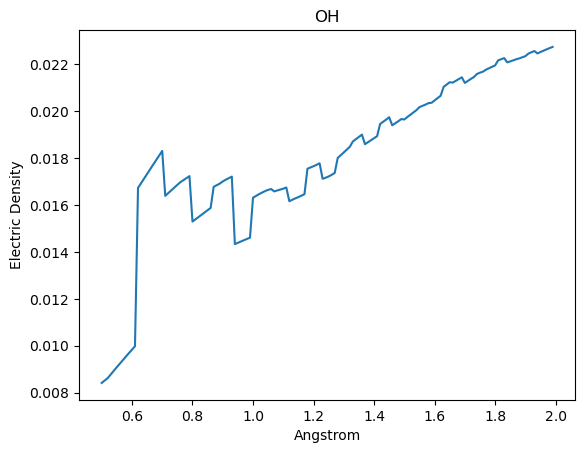

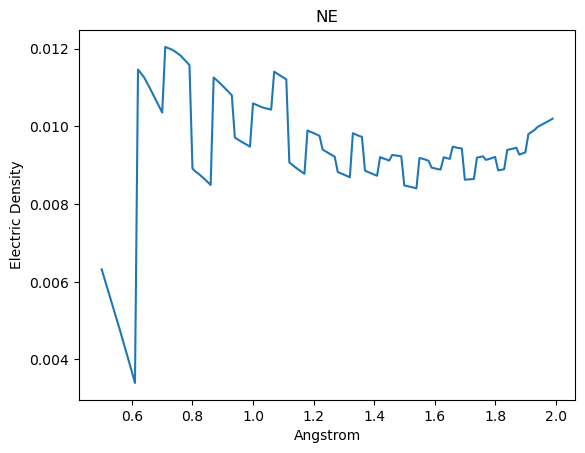

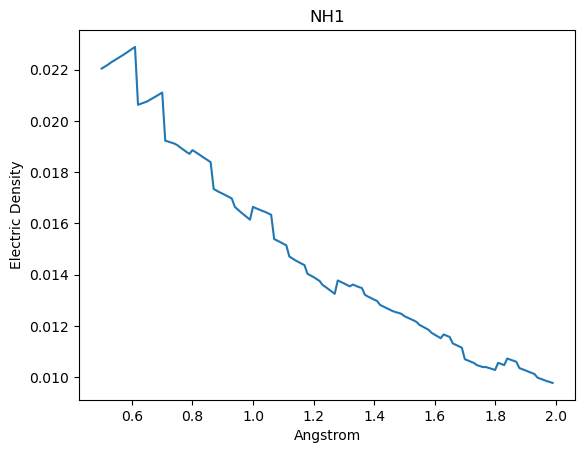

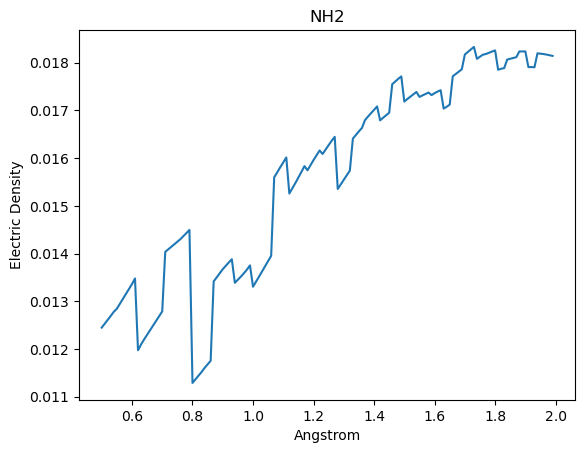

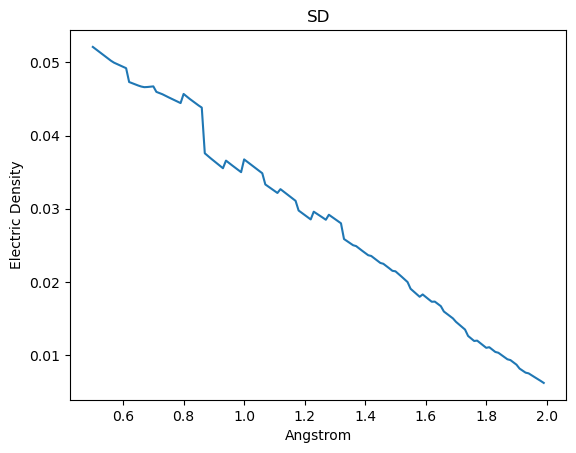

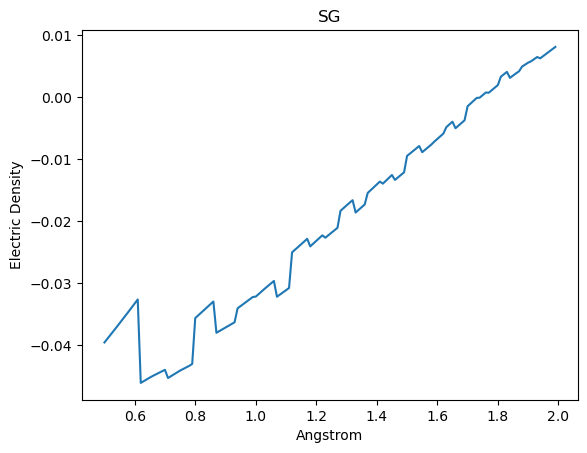

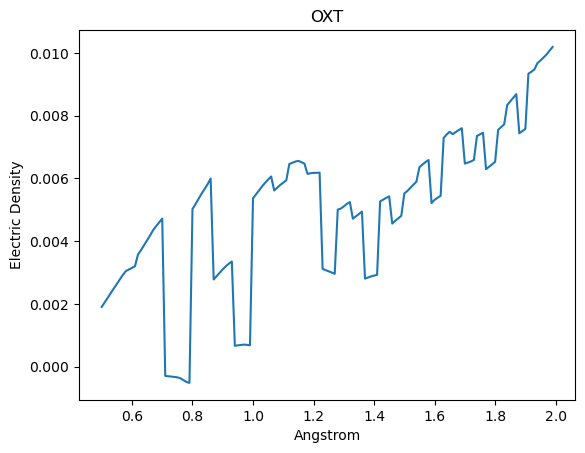

In [13]:
for atom, grid_points in grid_points_with_atoms.items():
    L = []
    for value in grid_points.values():
        L.append(np.mean(interp_func(value)))
    plt.title(atom)
    plt.plot(np.arange(0.5, 2, 0.01), L)
    plt.xlabel("Angstrom")
    plt.ylabel("Electric Density")
    plt.show()


In [ ]:
y_log = np.log(interp_func(points) - data.min())


Text(0, 0.5, 'Electric Density')

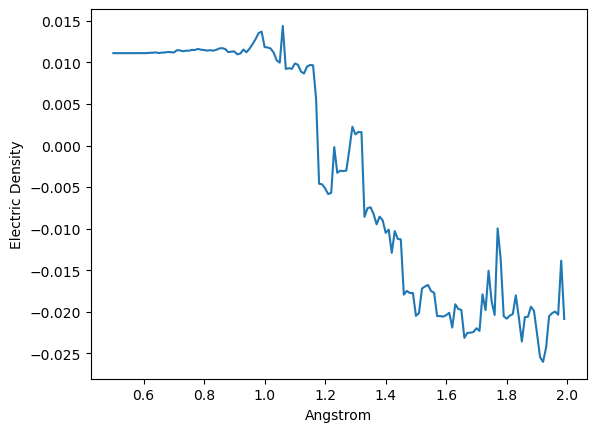

In [51]:
L = []
for value in grid_points.values():
    L.append(np.mean(interp_func(value)))
plt.plot(np.arange(0.5, 2, 0.01), L)
plt.xlabel("Angstrom")
plt.ylabel("Electric Density")


In [45]:
numbers_of_each_type = {residue_name: (df[df["residue_name"] == residue_name]["residue_number"]).nunique(
) for residue_name in df["residue_name"].unique()}


In [46]:
numbers_of_each_type.values()


dict_values([30, 32, 15, 14, 33, 13, 21, 15, 10, 3, 19, 19, 12, 6, 6, 3, 15, 4, 3])

In [24]:
qeb = QEB(
    types_of_proteins=len(numbers_of_each_type.values()),
    numbers_of_each_type=list(numbers_of_each_type.values()),
    grid_points=np.repeat(np.array([1, 2, 3]), 50000),
    variances_of_error=[[1]*3, [1.3]*2]*10,
    data_log_list=list(y_log)
)
